# Pulse Clipping Notebook 2: Scaling Validation

The Precision spectrum and oscillation experiment **(PROSPECT)** measures the spectrum of reactor anti-electron neutrinos by measuring the prompt and delayed coincidence of inverse beta decays **(IBDs)**. This is done by inspecting the readout from a network of photo-multiplying tubes **(PMTs)** attached to an 11 by 14 grid of lithium loaded liquid scintillators. After a particle event deposits energy into the active volume, the PMTs sample the digitized signal and lower-level analysis is performed on the waveform. The resulting measurement parameters extracted from the waveform are used in higher-level processing environments. At high energy, typically beyond 15 MeV<sub>ee</sub>, the waveform *oversaturates* the PMT, and the measurement parameters become difficult to extract.          

This series of notebooks attempts to address this clipping problem by constructing a map between the measurement parameters and the amount of clipping. This is notebook number 2. This analysis will address if the integration methods used to determine the PSD and area in the subsequent notebooks are consistent with the PROSPECT analysis. 

In [15]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import os

from ROOT import *
from helper import *

## Comparing Measurement Parameters ##
In this analysis, the pulse area and Pulse Shaped Discrimination **(PSD)** figure of merit are extracted from the analysis. Furthermore, the analysis extension provided by Blaine Heffron allows analyzers to access the waveforms of individual particles. As a result, our calculated parameters are contrasted against the calibrated P2X framework.     

In [16]:
df_heightcut_accumulate = pd.read_pickle('Templates/raw/s011_f00001_ts1520181395-2000_15500_maxheightcut.pkl')
df_heightcut_accumulate = df_heightcut_accumulate[df_heightcut_accumulate.maxheight < 15000]
df_heightcut_accumulate = df_heightcut_accumulate[df_heightcut_accumulate.area > 1000]
#df_heightcut_accumulate = pd.read_pickle('Templates/raw/s011_f00001_ts1520181395.pkl')
df_heightcut_accumulate

,event_number,det_number,arrival_time,area,psd,pulse,pid,simtruth_E,simtruth_Z,maxheight
8540,41,27,8.237818e+07,49424.445312,0.143136,"[3, 1, 0, 1, 13, 18, 148, 1321, 4128, 6630, 66...",0,0.0,0.0,6664
22971,112,85,2.218948e+08,46591.554688,0.117947,"[4, 1, 1, -2, 0, 1, 222, 2206, 5955, 7712, 740...",0,0.0,0.0,7712
22974,112,84,2.218948e+08,19886.666016,0.154796,"[3, 3, 2, -1, 4, 6, 163, 881, 1888, 2427, 2608...",0,0.0,0.0,2608
30379,147,193,2.906709e+08,32234.000000,0.172394,"[-1, 0, 0, 0, 0, 0, 14, 355, 2078, 3705, 3680,...",0,0.0,0.0,3732
41778,203,49,4.007110e+08,91582.250000,0.150037,"[0, 0, 1, -4, -2, 3, 92, 1833, 6870, 10949, 11...",0,0.0,0.0,11667
...,...,...,...,...,...,...,...,...,...,...
5816217,151747,26,2.981958e+11,15257.777344,0.077048,"[2, 2, 2, 0, -1, 2, 26, 335, 1342, 2278, 2473,...",0,0.0,0.0,2473
5864359,151993,218,2.986792e+11,15133.666992,0.137319,"[-4, 0, -1, -3, 2, 5, 168, 1203, 2649, 2475, 1...",0,0.0,0.0,2649
5864361,151993,188,2.986792e+11,30073.333984,0.139099,"[4, 0, 2, -1, 2, 7, 56, 1075, 3791, 4762, 4128...",0,0.0,0.0,4762
5864362,151993,189,2.986792e+11,19740.888672,0.152801,"[-1, -1, 0, 2, -5, 2, 83, 951, 2335, 2470, 239...",0,0.0,0.0,2470


<Figure size 2100x900 with 0 Axes>

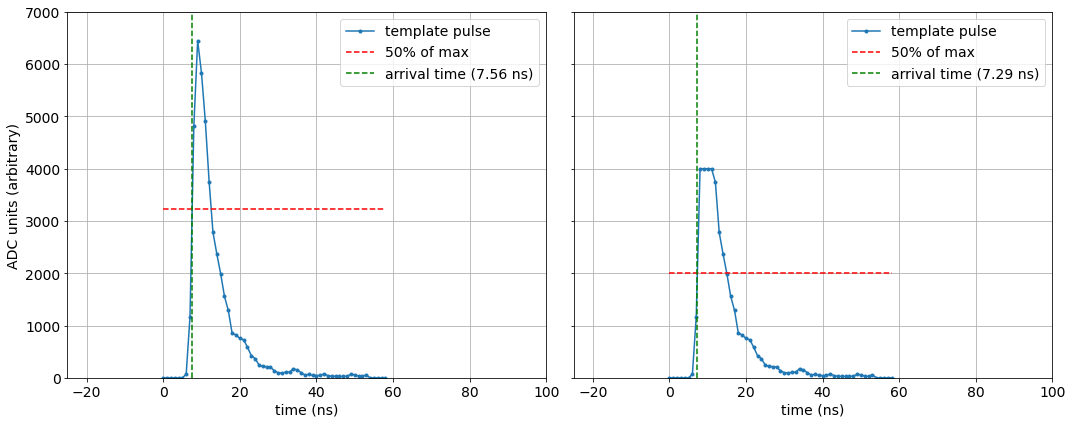

In [17]:
def Draw_Clipped_Example(x,y, clipping_height = 4000, y_lim = 9500):
    
    #x,y = get_xy_from_TGraph(graph)
    plt.figure(figsize=(14, 6), dpi=150)
    fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,6))
  
    ax[0].plot(x,y, linestyle='-', marker='.', label='template pulse')
    #ax[0].plot([x[0],x[-1]], [np.amax(y)/2,np.amax(y)/2], linestyle='--', marker='', color='r', label='50% of max')
    ax[0].plot([x[0],x[-1]], [get_half_level_crossing(x,y),get_half_level_crossing(x,y)], linestyle='--', marker='', color='r', label='50% of max')
    ax[0].plot([get_time(x, y), get_time(x, y)], [0,y_lim], linestyle='--', color='g', label='arrival time ('+str(np.round(get_time(x, y),2)) + ' ns)')
    ax[0].grid()
    ax[0].set_xlabel('time (ns)', fontsize=14); ax[0].set_ylabel('ADC units (arbitrary)', fontsize=14)
    ax[0].legend(fontsize=14)
    ax[0].set_ylim(0,y_lim)
    ax[0].set_xlim(-25, 100)
    ax[0].tick_params(axis='both', labelsize=14)

    yscaled_clipped = np.copy(y)
    yscaled_clipped[yscaled_clipped > clipping_height] = clipping_height

    ax[1].plot(x,yscaled_clipped, linestyle='-', marker='.', label='template pulse')
    ax[1].plot([x[0],x[-1]], [get_half_level_crossing(x,yscaled_clipped),get_half_level_crossing(x,yscaled_clipped)], linestyle='--', marker='', color='r', label='50% of max')
    #ax[1].plot([x[0],x[-1]], [np.amax(yscaled_clipped)/2,np.amax(yscaled_clipped)/2], linestyle='--', marker='', color='r', label='50% of max')
    ax[1].plot([get_time(x, yscaled_clipped), get_time(x, yscaled_clipped)], [0,y_lim], linestyle='--', color='g', label='arrival time ('+str(np.round(get_time(x, yscaled_clipped),2)) + ' ns)')
    ax[1].grid()
    ax[1].set_xlabel('time (ns)', fontsize=14); ax[0].set_ylabel('ADC units (arbitrary)', fontsize=14)
    ax[1].legend(fontsize=14)
    ax[1].set_ylim(0,y_lim)
    ax[1].set_xlim(-25, 100)
    ax[1].tick_params(axis='both', labelsize=14)

    plt.tight_layout()
    

#test the graph 
row = df_heightcut_accumulate.iloc[5]
y_array = np.asarray(row[5])
x_array = np.arange(len(y_array))

Draw_Clipped_Example(x_array,y_array, clipping_height = 4000, y_lim = 7000)

### Method ###
The pickle file contains serialized data representing each cell deposit. These include the arrival time, PSD, and the distribution of analogue-to-digital **(ADC)** samples. In this case, only the events with a maximum pulse height between 2000 and 15000 ADC samples were selected to avoid using clipped signals. This corresponds to approximately 24477 waveforms. For each waveform, the PSD and total area are calculated and compared to their *true* value determined through the PROSPECT2X-Analysis framework.   

In [18]:
psd = np.asarray(df_heightcut_accumulate['psd'])
area = np.asarray(df_heightcut_accumulate['area'])

psd_calcs = np.asarray([])
area_calcs = np.asarray([])

#for index, row in df_heightcut_accumulate_normalized.iterrows(): 
for index, row in df_heightcut_accumulate.iterrows(): 
    y = np.asarray(row[5])
    x = np.arange(len(y))
    
    # remove the baseline
    baselinearray = y[0:np.argmax(y)-5]
    baseline = np.mean(baselinearray)
    y = y-baseline
    
    psdcalc = get_PSD_discretepts(x, y)
    areacalc = get_total_area_discretepts(x, y)
    
    psd_calcs = np.append(psd_calcs, psdcalc)
    area_calcs = np.append(area_calcs, areacalc)

In [19]:
psdhist = ROOT.TH1F('psd','psd',50,0.0,0.3)
psdhist_calc = ROOT.TH1F('psdcalc','psdcalc',50,0.0,0.3)
psd_2D_hist = ROOT.TH2F('psdcalc2D','psdcalc2D',50,0.0,0.2, 50,0.0,0.2)

areahist = ROOT.TH1F('area','area',50,0.0,150000)
areahist_calc = ROOT.TH1F('areacalc','areacalc',50,0.0,150000)
area_2D_hist = ROOT.TH2F('areacalc2D','areacalc2D',50,0.0,150000, 50,0.0,150000)

for i in range(len(psd_calcs)): 
    psdhist.Fill(psd[i])
    psdhist_calc.Fill(psd_calcs[i])
    psd_2D_hist.Fill(psd_calcs[i],psd[i])
    
    areahist.Fill(area[i])
    areahist_calc.Fill(area_calcs[i])
    area_2D_hist.Fill(area_calcs[i], area[i])
    
psdhist.SetFillStyle(3354)
psdhist_calc.SetFillStyle(3345)
psdhist.SetFillColor(2) #red
psdhist_calc.SetFillColor(4) #blue
psdhist.SetLineColor(2)

areahist.SetFillStyle(3354)
areahist_calc.SetFillStyle(3345)
areahist.SetFillColor(2) # red
areahist_calc.SetFillColor(4) #blue
areahist.SetLineColor(2)

legend = ROOT.TLegend(0.55,0.75,0.9,0.9);
legend.AddEntry(psdhist,"PROSPECT2X_Analysis","F");
legend.AddEntry(psdhist_calc,"Calculated","F");

Warning in <TROOT::Append>: Replacing existing TH1: psd (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: psdcalc (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: psdcalc2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: area (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: areacalc (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: areacalc2D (Potential memory leak).


#### Pulse Shape Discrimination ####
The PSD reconstruction used in our analysis is contrasted against the P2X output stored in the pickle file. Our calculations are depicted in blue, and the P2X output is displayed in red. Both integration techniques utilize trapezoidal interpellation; however, they seem to differ. This may be due how the limits of integration are defined relative to the 50% level crossing. Alternatively, the interpolation package relies on a large quantity of data to converge. The leading edge of the waveform has significantly fewer ADC sample triggers than the tailing edge; this may cause the interpolation to diverge.   

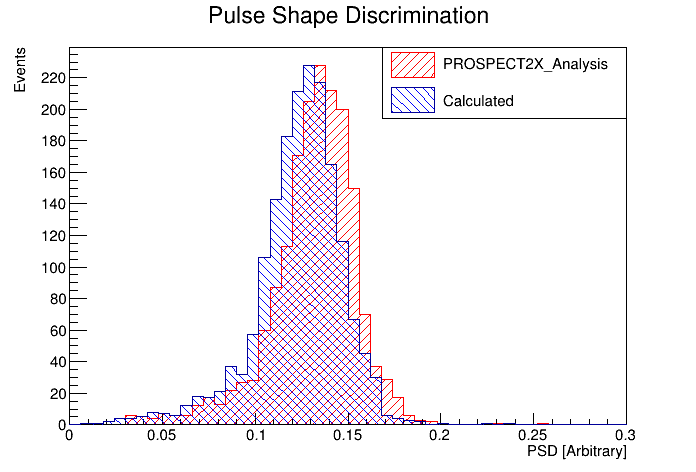

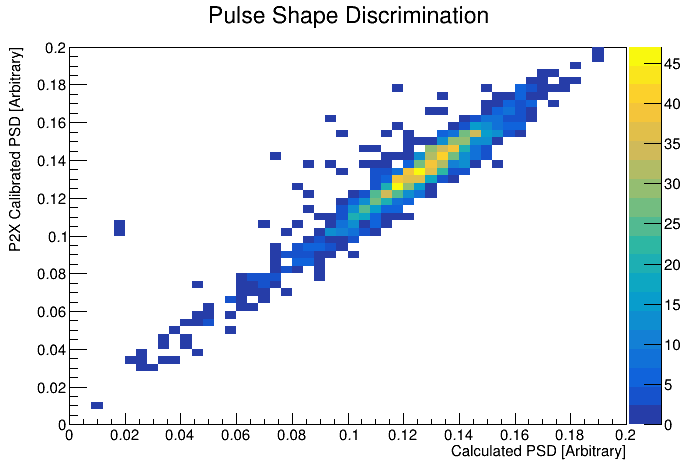

In [20]:
# compare our calculated PSD to the P2X output
gStyle.SetOptStat(0)
c = ROOT.TCanvas()
psdhist.SetTitle("Pulse Shape Discrimination")
psdhist.GetXaxis().SetTitle("PSD [Arbitrary]")
psdhist.GetYaxis().SetTitle("Events")
psdhist.Draw()
psdhist_calc.Draw('same')
legend.Draw();
c.Draw()

c2 = ROOT.TCanvas()
psd_2D_hist.SetTitle("Pulse Shape Discrimination")
psd_2D_hist.GetXaxis().SetTitle("Calculated PSD [Arbitrary]")
psd_2D_hist.GetYaxis().SetTitle("P2X Calibrated PSD [Arbitrary]")
psd_2D_hist.Draw("COLZ")
c2.Draw()

#### Pulse Area ####
Next, we will examine the area of the waveform. In a similar method, the true pulse area is compared against our calculations. This tests the rigidity of the trapezoidal integration technique implemented in numpy. The results are expressed in the histogram and response matrix below. 

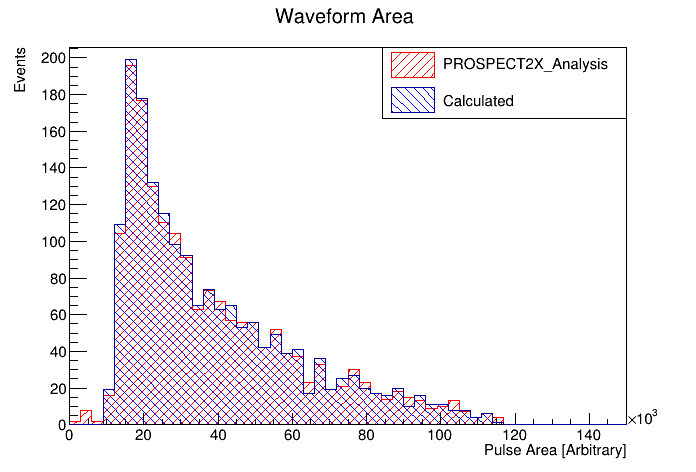

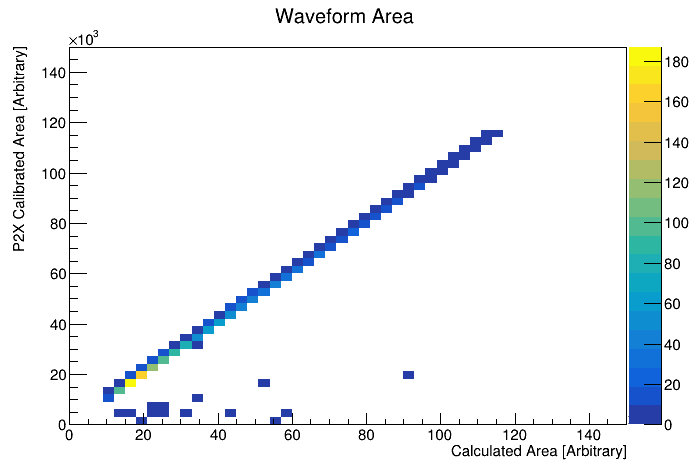

In [21]:
c3 = ROOT.TCanvas()
areahist.SetTitle("Waveform Area")
areahist.GetXaxis().SetTitle("Pulse Area [Arbitrary]")
areahist.GetYaxis().SetTitle("Events")
areahist.Draw()
areahist_calc.Draw('same')
legend.Draw('same')
c3.Draw()

c4 = ROOT.TCanvas()
area_2D_hist.SetTitle("Waveform Area")
area_2D_hist.GetXaxis().SetTitle("Calculated Area [Arbitrary]")
area_2D_hist.GetYaxis().SetTitle("P2X Calibrated Area [Arbitrary]")
area_2D_hist.Draw("COLZ")
c4.Draw()

## Discussions ##
The diagonality of the waveform area response matrix suggests that the total waveform area is calculated appropriately for most events. The trapezoidal technique, however, seems to fail for shallow distributions of ADC samples. This may contribute to the incorrect PSD calculation across the tail end of the distribution 

The PSD computation relies on an accurate reconstruction of the arrival time because the limits of integration are defined with respect to the 50% level crossing. If the interpolation fails, this region cannot be determined properly. The word presented in these notebooks may, however, be sufficient to adjust for the clipped waveform. 

The final issue to resolve is selecting which waveform template is appropriate to construct the PSD-time map. The simulated templates are selected to adjust for non-linear energy scaling within the **P2X** analysis framework; however, suggesting that a waveform best represents all muon pulses is nontrivial. Instead, a new template can be constructed using measured data from unclipped electron-recoil events. This is the subject of the third notebook. 